## Problem 1-1

In [1]:
# initialize
rm(list = ls());

library(igraph)
library(ggplot2)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



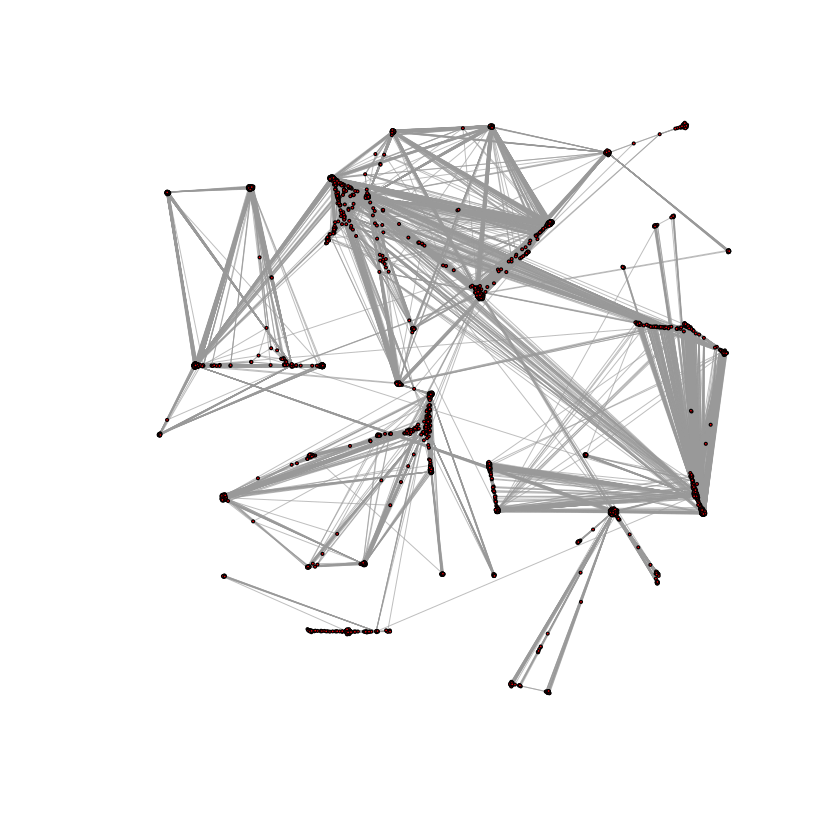

In [2]:
edge_list <- read.table("/Users/kgicmd/Downloads/facebook_combined.txt");
node_list1 <- names(table(edge_list$V1));
node_list2 <- names(table(edge_list$V2));
node_list <- union(node_list1, node_list2);

net <- graph_from_data_frame(d=edge_list, vertices=node_list, directed=FALSE) 
plot(net,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

### Question 1

In [3]:
is.connected(net);

[1] TRUE

### Question 2

In [4]:
d<-diameter(net, directed = FALSE, unconnected =FALSE);
print(d);

[1] 8


### Question 3

In [5]:
net_degrees <- degree(net);
net_degrees_hist <- as.data.frame(table(net_degrees));

net_degrees_hist[,1] <- as.numeric(net_degrees_hist[,1]);

In [8]:
# change to probablity
net_degrees_hist[,2]  <- net_degrees_hist[,2] / sum(net_degrees_hist$Freq);

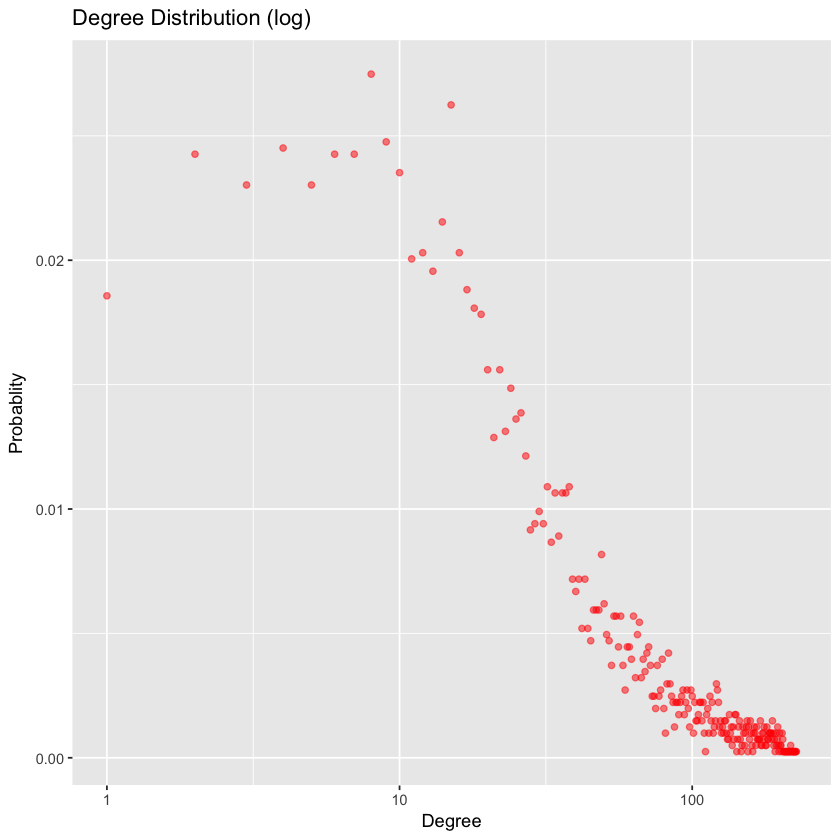

In [13]:
# plot
p <- ggplot(net_degrees_hist, aes(x = net_degrees, y = Freq)) + geom_point(alpha=0.5, color="red");
#p <- p + geom_smooth(method = "lm")
p <- p + scale_x_continuous("Degree",
                            breaks = c(1, 10, 100, 1000,2000),
                            trans = "log10");
p <- p + labs(y = "Probablity")
p <-  p + ggtitle("Degree Distribution (log)")
p

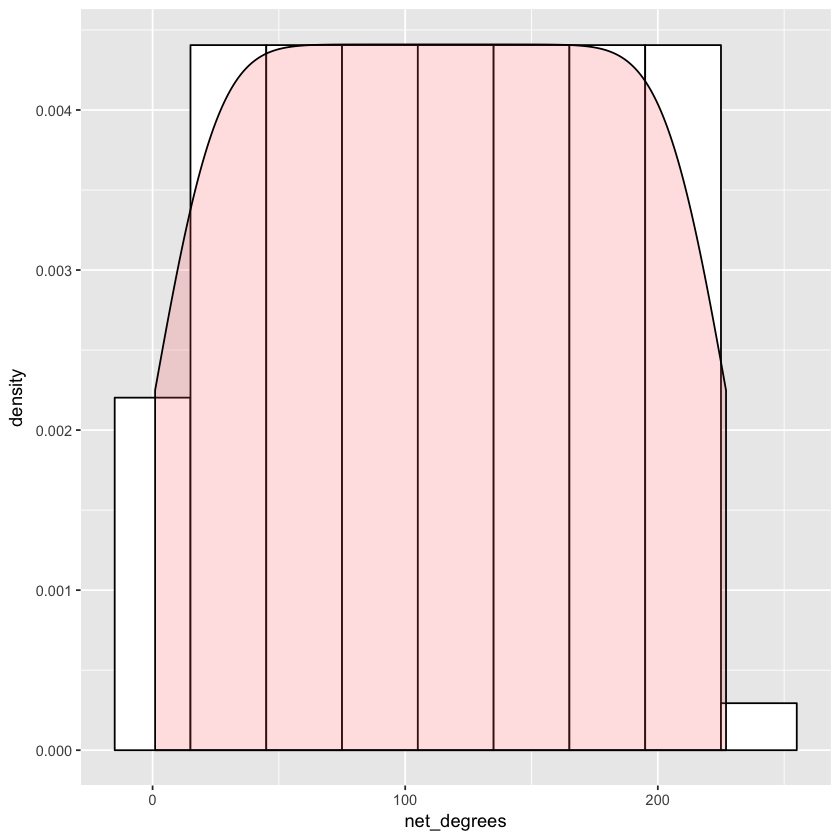

In [14]:
# histogram
p <- ggplot(net_degrees_hist, aes(x=net_degrees));
p <- p + geom_histogram(aes(y=..density..),color="black", fill="white", binwidth = 30);
p <- p + geom_density(alpha=.2, fill="#FF6666");
p

### Question 4

In [25]:
getAlpha<-function(g,xmin){
  d <- degree(g);
  fit <- fit_power_law(d,xmin=xmin);
  return(fit$alpha);
}

slope <- -getAlpha(net ,10);
print(paste("slope is", slope))

[1] "slope is -1.72349073613742"


### Question 5

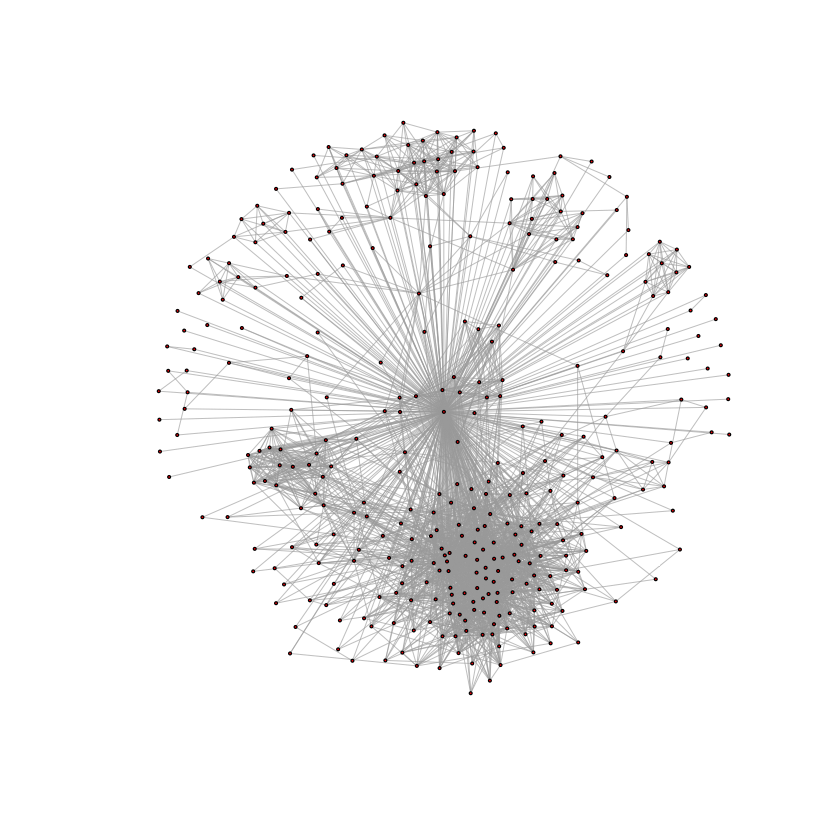

In [26]:
sub_edge_list <- edge_list[edge_list$V1 == 0,];
sub_node_list1 <- names(table(sub_edge_list$V1));
sub_node_list2 <- names(table(sub_edge_list$V2));
sub_node_list <- union(sub_node_list1, sub_node_list2);

# gengerate induced graph
sub_net <- induced_subgraph(net, sub_node_list);

plot(sub_net,vertex.size=1,vertex.label=NA, vertex.color="red",
     edge.width=0.5,edge.arrow.size=0.1);

In [27]:
# number of nodes
print(paste("number of nodes = ",length(sub_node_list)));

[1] "number of nodes =  348"


In [28]:
# number of edges
print(paste("number of edges = ", gsize(sub_net)));

[1] "number of edges =  2866"


### Question 6

In [29]:
diam <- diameter(sub_net);
print(paste("diameter of the sub-network = ",diam));

[1] "diameter of the sub-network =  2"


# Problem 1-3

### Question 8

In [30]:
neighbor_count <- c();
node_list <- as.integer(node_list);
for(v in node_list){
  neighbor_count <- append(neighbor_count,length(neighbors(net, v+1, mode = "total")));
}

# number of nodes who have > 200 neighbors
cr_number <- length(neighbor_count[neighbor_count > 200]);
print(paste("number of core nodes = ", cr_number));
# average number of neighbors
print(paste("average number of core neighbors = ", mean(neighbor_count[neighbor_count > 200])));

[1] "number of core nodes =  40"
[1] "average number of core neighbors =  279.375"


### Question 10

In [32]:
# extract peronalized network
person_net <- function(net, vertex, edge_list){
  sub_edge_list <- edge_list[edge_list$V1 == vertex,];
  sub_node_list1 <- names(table(sub_edge_list$V1));
  sub_node_list2 <- names(table(sub_edge_list$V2));
  sub_node_list <- union(sub_node_list1, sub_node_list2);
  
  ind_graph <- induced_subgraph(net, sub_node_list);
  return(ind_graph);
}

In [15]:
# parse parameters
parse_para <- function(net, vertex, edge_list){
  ind_net <- person_net(net, vertex, edge_list);
  
  # fast greedy
  com_greedy <- cluster_fast_greedy(ind_net);
  greedy_mod <- modularity(ind_net,com_greedy$membership);
  
  jpeg(paste("fast_greedy_",vertex,".jpg"))
  plot(com_greedy,ind_net,vertex.size=2,vertex.label=NA);
  dev.off()
  
  # edge betweenness
  com_eb <- cluster_edge_betweenness(ind_net, directed=FALSE);
  eb_mod <- modularity(ind_net,com_eb$membership);
  
  jpeg(paste("edge_betweenness_",vertex,".jpg"));
  plot(com_eb,ind_net,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # Infomap
  com_if_mp <- cluster_infomap(ind_net, modularity = TRUE);
  if_map_mod <- modularity(ind_net,com_if_mp$membership);
  
  jpeg(paste("info_map_",vertex,".jpg"));
  plot(com_if_mp,ind_net,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # return modularity
  para_tmp <- c(vertex, greedy_mod, eb_mod, if_map_mod);
  return(para_tmp)
}

In [16]:
vertex_list <- c(0, 108, 349, 484, 1087);
para_matrix <- rep(0,4);
for (vertex in vertex_list){
  para_tmp <- parse_para(net, vertex, edge_list);
  para_matrix <- rbind(para_matrix, para_tmp);
}
para_matrix <- para_matrix[2:6,];
print(para_matrix)

         [,1]        [,2]      [,3]       [,4]
para_tmp    0  0.41310137 0.3533022 0.38911847
para_tmp  108 -0.01388889 0.0000000 0.00000000
para_tmp  349 -0.05555556 0.0000000 0.00000000
para_tmp  484  0.33654410 0.2307840 0.08848587
para_tmp 1087  0.03061224 0.0000000 0.00000000


### Question 9

In [17]:
person_net_rm <- function(net, vertex, edge_list){
  sub_edge_list <- edge_list[edge_list$V1 == vertex,];
  sub_node_list1 <- names(table(sub_edge_list$V1));
  sub_node_list2 <- names(table(sub_edge_list$V2));
  sub_node_list <- union(sub_node_list1, sub_node_list2);
  
  ind_graph <- induced_subgraph(net, sub_node_list);
  # remove core node
  ind_graph_rm <- delete_vertices(ind_graph, as.character(vertex));
  return(ind_graph_rm);
}

In [18]:
# parse parameters
parse_para_rm <- function(net, vertex, edge_list){
  ind_graph_rm <- person_net_rm(net, vertex, edge_list);
  
  # fast greedy
  com_greedy <- cluster_fast_greedy(ind_graph_rm);
  greedy_mod <- modularity(ind_graph_rm,com_greedy$membership);
  
  jpeg(paste("fast_greedy_rm_",vertex,".jpg"))
  plot(com_greedy,ind_graph_rm,vertex.size=2,vertex.label=NA);
  dev.off()
  
  # edge betweenness
  com_eb <- cluster_edge_betweenness(ind_graph_rm, directed=FALSE);
  eb_mod <- modularity(ind_graph_rm,com_eb$membership);
  
  jpeg(paste("edge_betweenness_rm_",vertex,".jpg"));
  plot(com_eb,ind_graph_rm,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # Infomap
  com_if_mp <- cluster_infomap(ind_graph_rm, modularity = TRUE);
  if_map_mod <- modularity(ind_graph_rm,com_if_mp$membership);
  
  jpeg(paste("info_map_rm_",vertex,".jpg"));
  plot(com_if_mp,ind_graph_rm,vertex.size=2,vertex.label=NA);
  dev.off();
  
  # return modularity
  para_tmp <- c(vertex, greedy_mod, eb_mod, if_map_mod);
  return(para_tmp)
}

In [19]:
vertex_list <- c(0, 108, 349, 484, 1087);
para_matrix_rm <- rep(0,4);
for (vertex in vertex_list){
  para_tmp <- parse_para_rm(net, vertex, edge_list);
  para_matrix_rm <- rbind(para_matrix_rm, para_tmp);
}
para_matrix_rm <- para_matrix_rm[2:6,];
print(para_matrix_rm)

         [,1]        [,2]      [,3]      [,4]
para_tmp    0  0.44185327 0.4161461 0.4180077
para_tmp  108 -0.01652893 0.0000000 0.0000000
para_tmp  349 -0.08000000 0.0000000 0.0000000
para_tmp  484  0.35731253 0.2663497 0.3364081
para_tmp 1087  0.16666667 0.1666667 0.0000000


### Additional to Q12

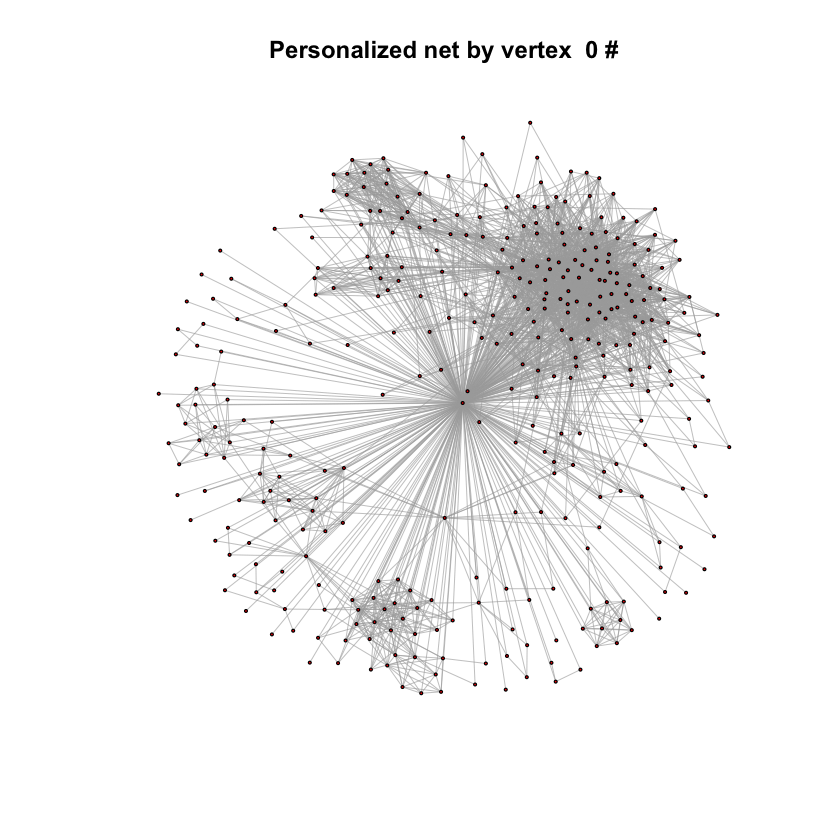

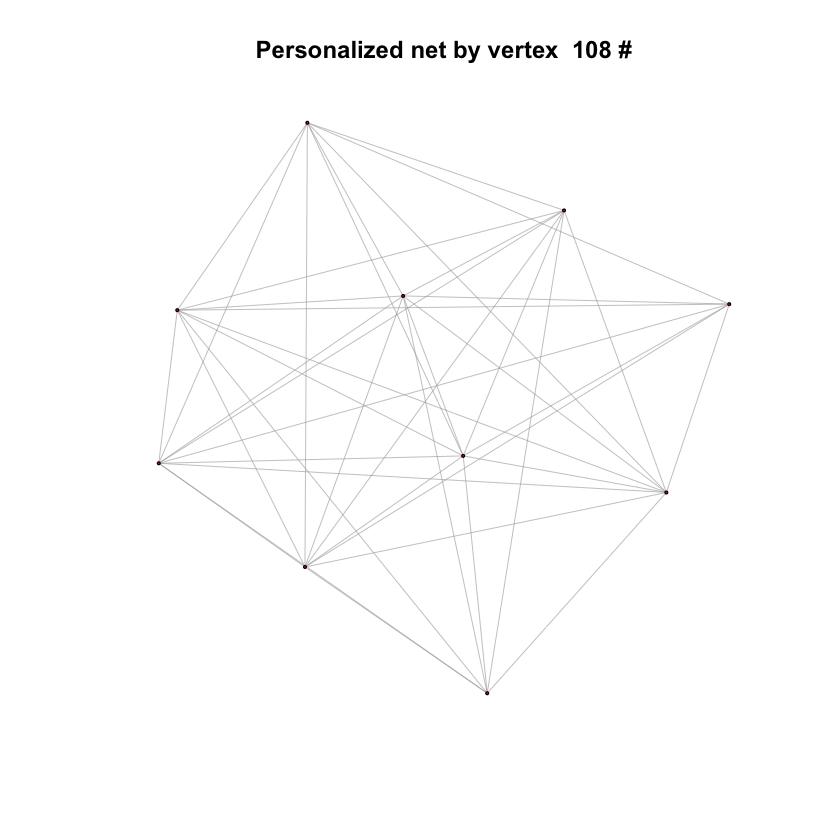

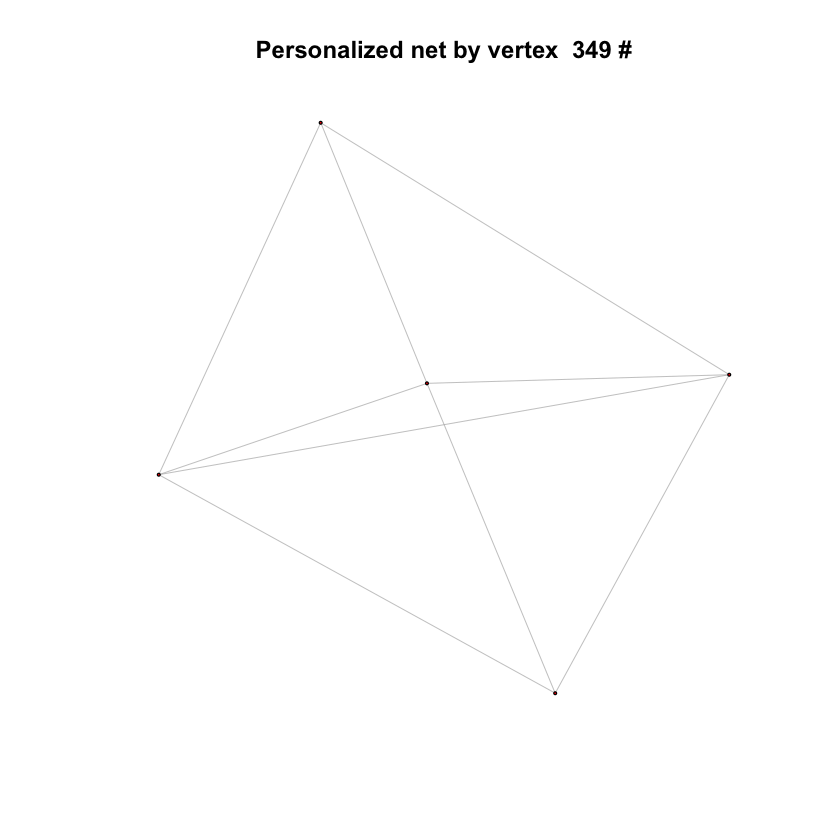

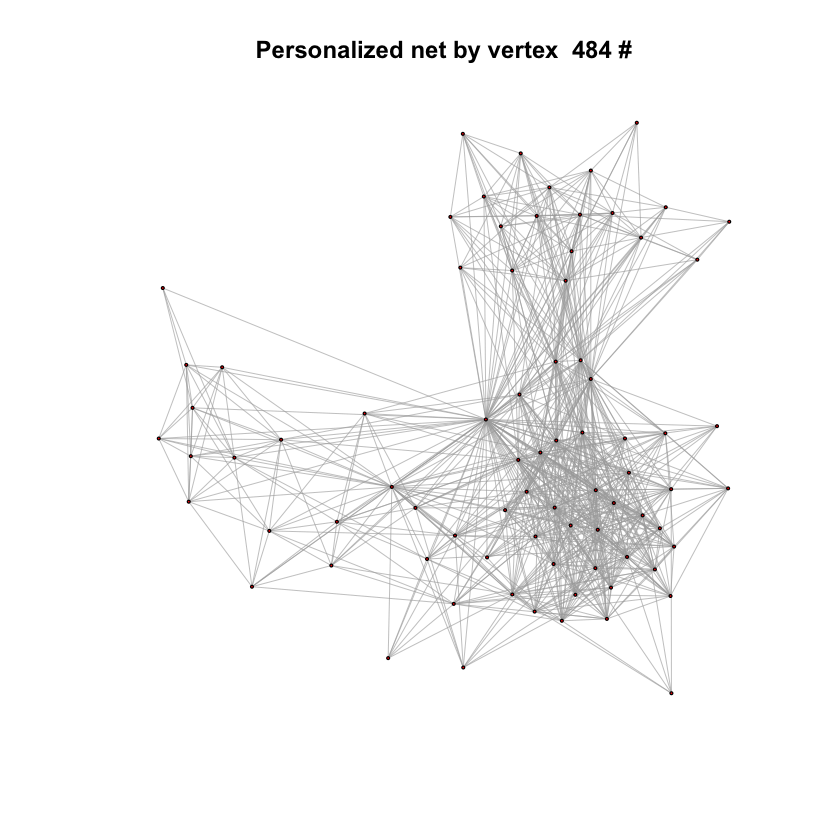

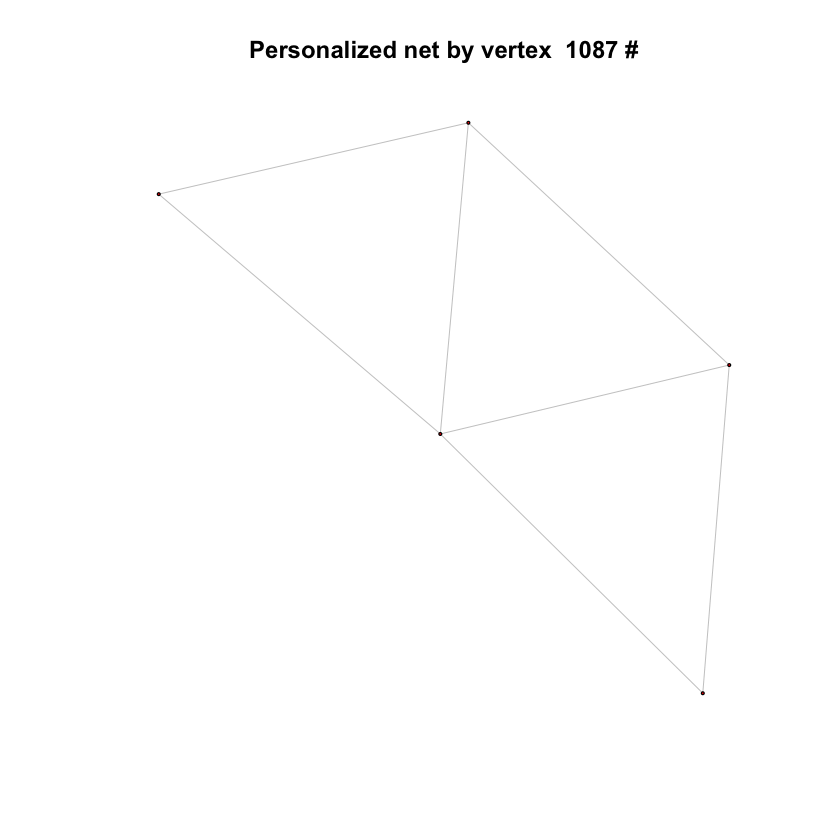

In [34]:
vertex_list <- c(0, 108, 349, 484, 1087);
for (vertex in vertex_list){
    person_net_by_v <- person_net(net, vertex, edge_list);
    plot(person_net_by_v,vertex.size=1,vertex.label=NA, vertex.color="red",
         edge.width=0.5,edge.arrow.size=0.1);
    title(main = paste("Personalized net by vertex ", vertex, "#"));
}